### Principal Component Analysis

#### Some basic data exploration 

In [1]:
from datetime import date

import pandas_datareader.data as web
import pandas as pd
import matplotlib.ticker as mtick

In [2]:
report_start = date.fromisoformat('2020-01-01')
report_end = date.today()

In [3]:
data = web.get_data_fred(['DGS5', 'DGS10', 'T5YIE', 'T10YIE', 'T10Y2Y', 'T10Y3M'], report_start, report_end) / 100.
data.dropna(inplace=True)

columns_with_semiannual_comp = [0, 1, 3, 4]

# Converting all CMT Yields to APY (i.e. all but breakeven inflation rates)
data.iloc[:, columns_with_semiannual_comp] = (data.iloc[:, columns_with_semiannual_comp]/2 + 1)**2 - 1

In [4]:
data['10y Tr. Yield - 5y Tr. Yield'] = data.DGS10 - data.DGS5
data['10y Breakeven Infl. Rate - 5y Breakeven Infl. Rate'] = data.T10YIE - data.T5YIE
data.rename(columns={'T10Y2Y': '10y Tr. Yield - 2y Tr. Yield',
                     'T10Y3M': '10y Tr. Yield - 3m Tr. Yield'}, inplace=True)

In [5]:
# Get rid of columns no longer required
data.drop(columns=data.columns[0:4], inplace=True)

# Rearrange columns
data = data.iloc[:, [2, 3, 0, 1]]

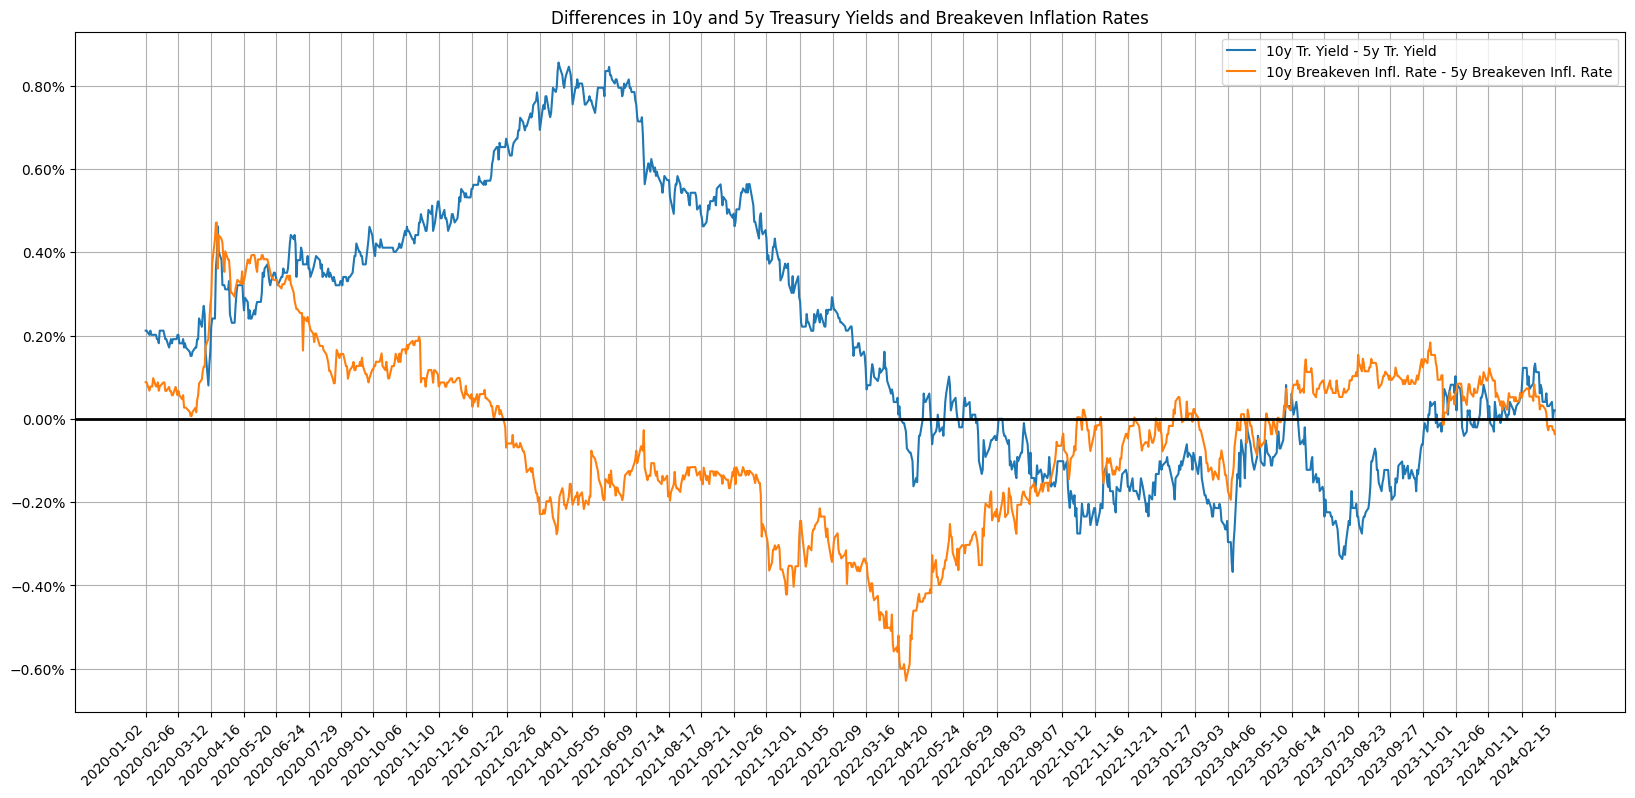

In [6]:
ax = data.iloc[:,:2].plot(figsize=(20,10), grid=True,
               title='Differences in 10y and 5y Treasury Yields and Breakeven Inflation Rates',
               xticks=data.index[::24], xlabel='', rot=45)
ax.axhline(y=0, lw=2, c='k')
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1))

### Principal Component Analysis

In [1]:
%matplotlib inline
import os
import io
import time
from datetime import date, datetime, timedelta
import pandas as pd
import numpy as np
import pandas_datareader.data as pdr
from pandas_datareader.fred import FredReader
import matplotlib.pyplot as plt
import seaborn as sns

/tmp/ipykernel_14908/1582632722.py:6: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
# download treasury curves from Fred
codes = ['DGS1MO', 'DGS3MO', 'DGS6MO', 'DGS1', 'DGS2', 'DGS3', 'DGS5', 'DGS7', 'DGS10', 'DGS20', 'DGS30']
end_date = datetime.today()
start_date = datetime(2000, 1, 1)
df = pd.DataFrame()

for code in codes:
    reader = FredReader(code, start_date, end_date)
    df0 = reader.read()
    df = df.merge(df0, how='outer', left_index=True, right_index=True, sort=False)
    reader.close()
df.dropna(axis = 0, inplace = True)
df = df['2020':]

In [3]:
df.head()

,DGS1MO,DGS3MO,DGS6MO,DGS1,DGS2,DGS3,DGS5,DGS7,DGS10,DGS20,DGS30
DATE,,,,,,,,,,,
2020-01-02,1.53,1.54,1.57,1.56,1.58,1.59,1.67,1.79,1.88,2.19,2.33
2020-01-03,1.52,1.52,1.55,1.55,1.53,1.54,1.59,1.71,1.80,2.11,2.26
2020-01-06,1.54,1.56,1.56,1.54,1.54,1.56,1.61,1.72,1.81,2.13,2.28
2020-01-07,1.52,1.54,1.56,1.53,1.54,1.55,1.62,1.74,1.83,2.16,2.31
2020-01-08,1.50,1.54,1.56,1.55,1.58,1.61,1.67,1.78,1.87,2.21,2.35


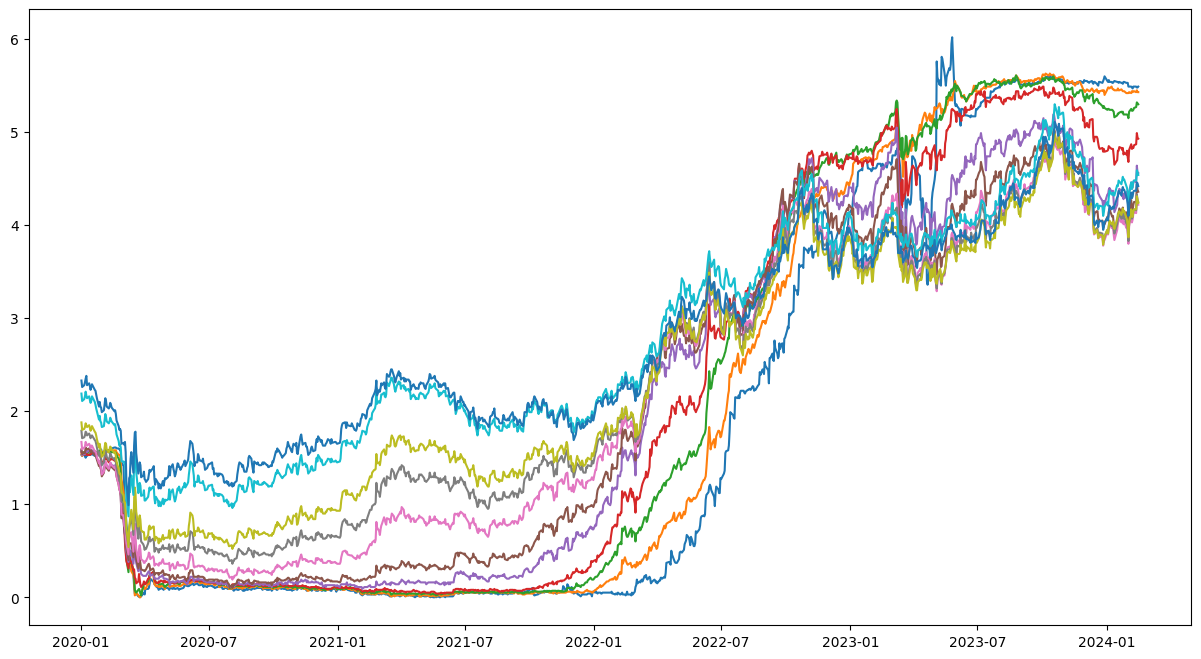

In [4]:
# view the yield curve
plt.figure(figsize=(15,8))
plt.plot(df)
plt.show()

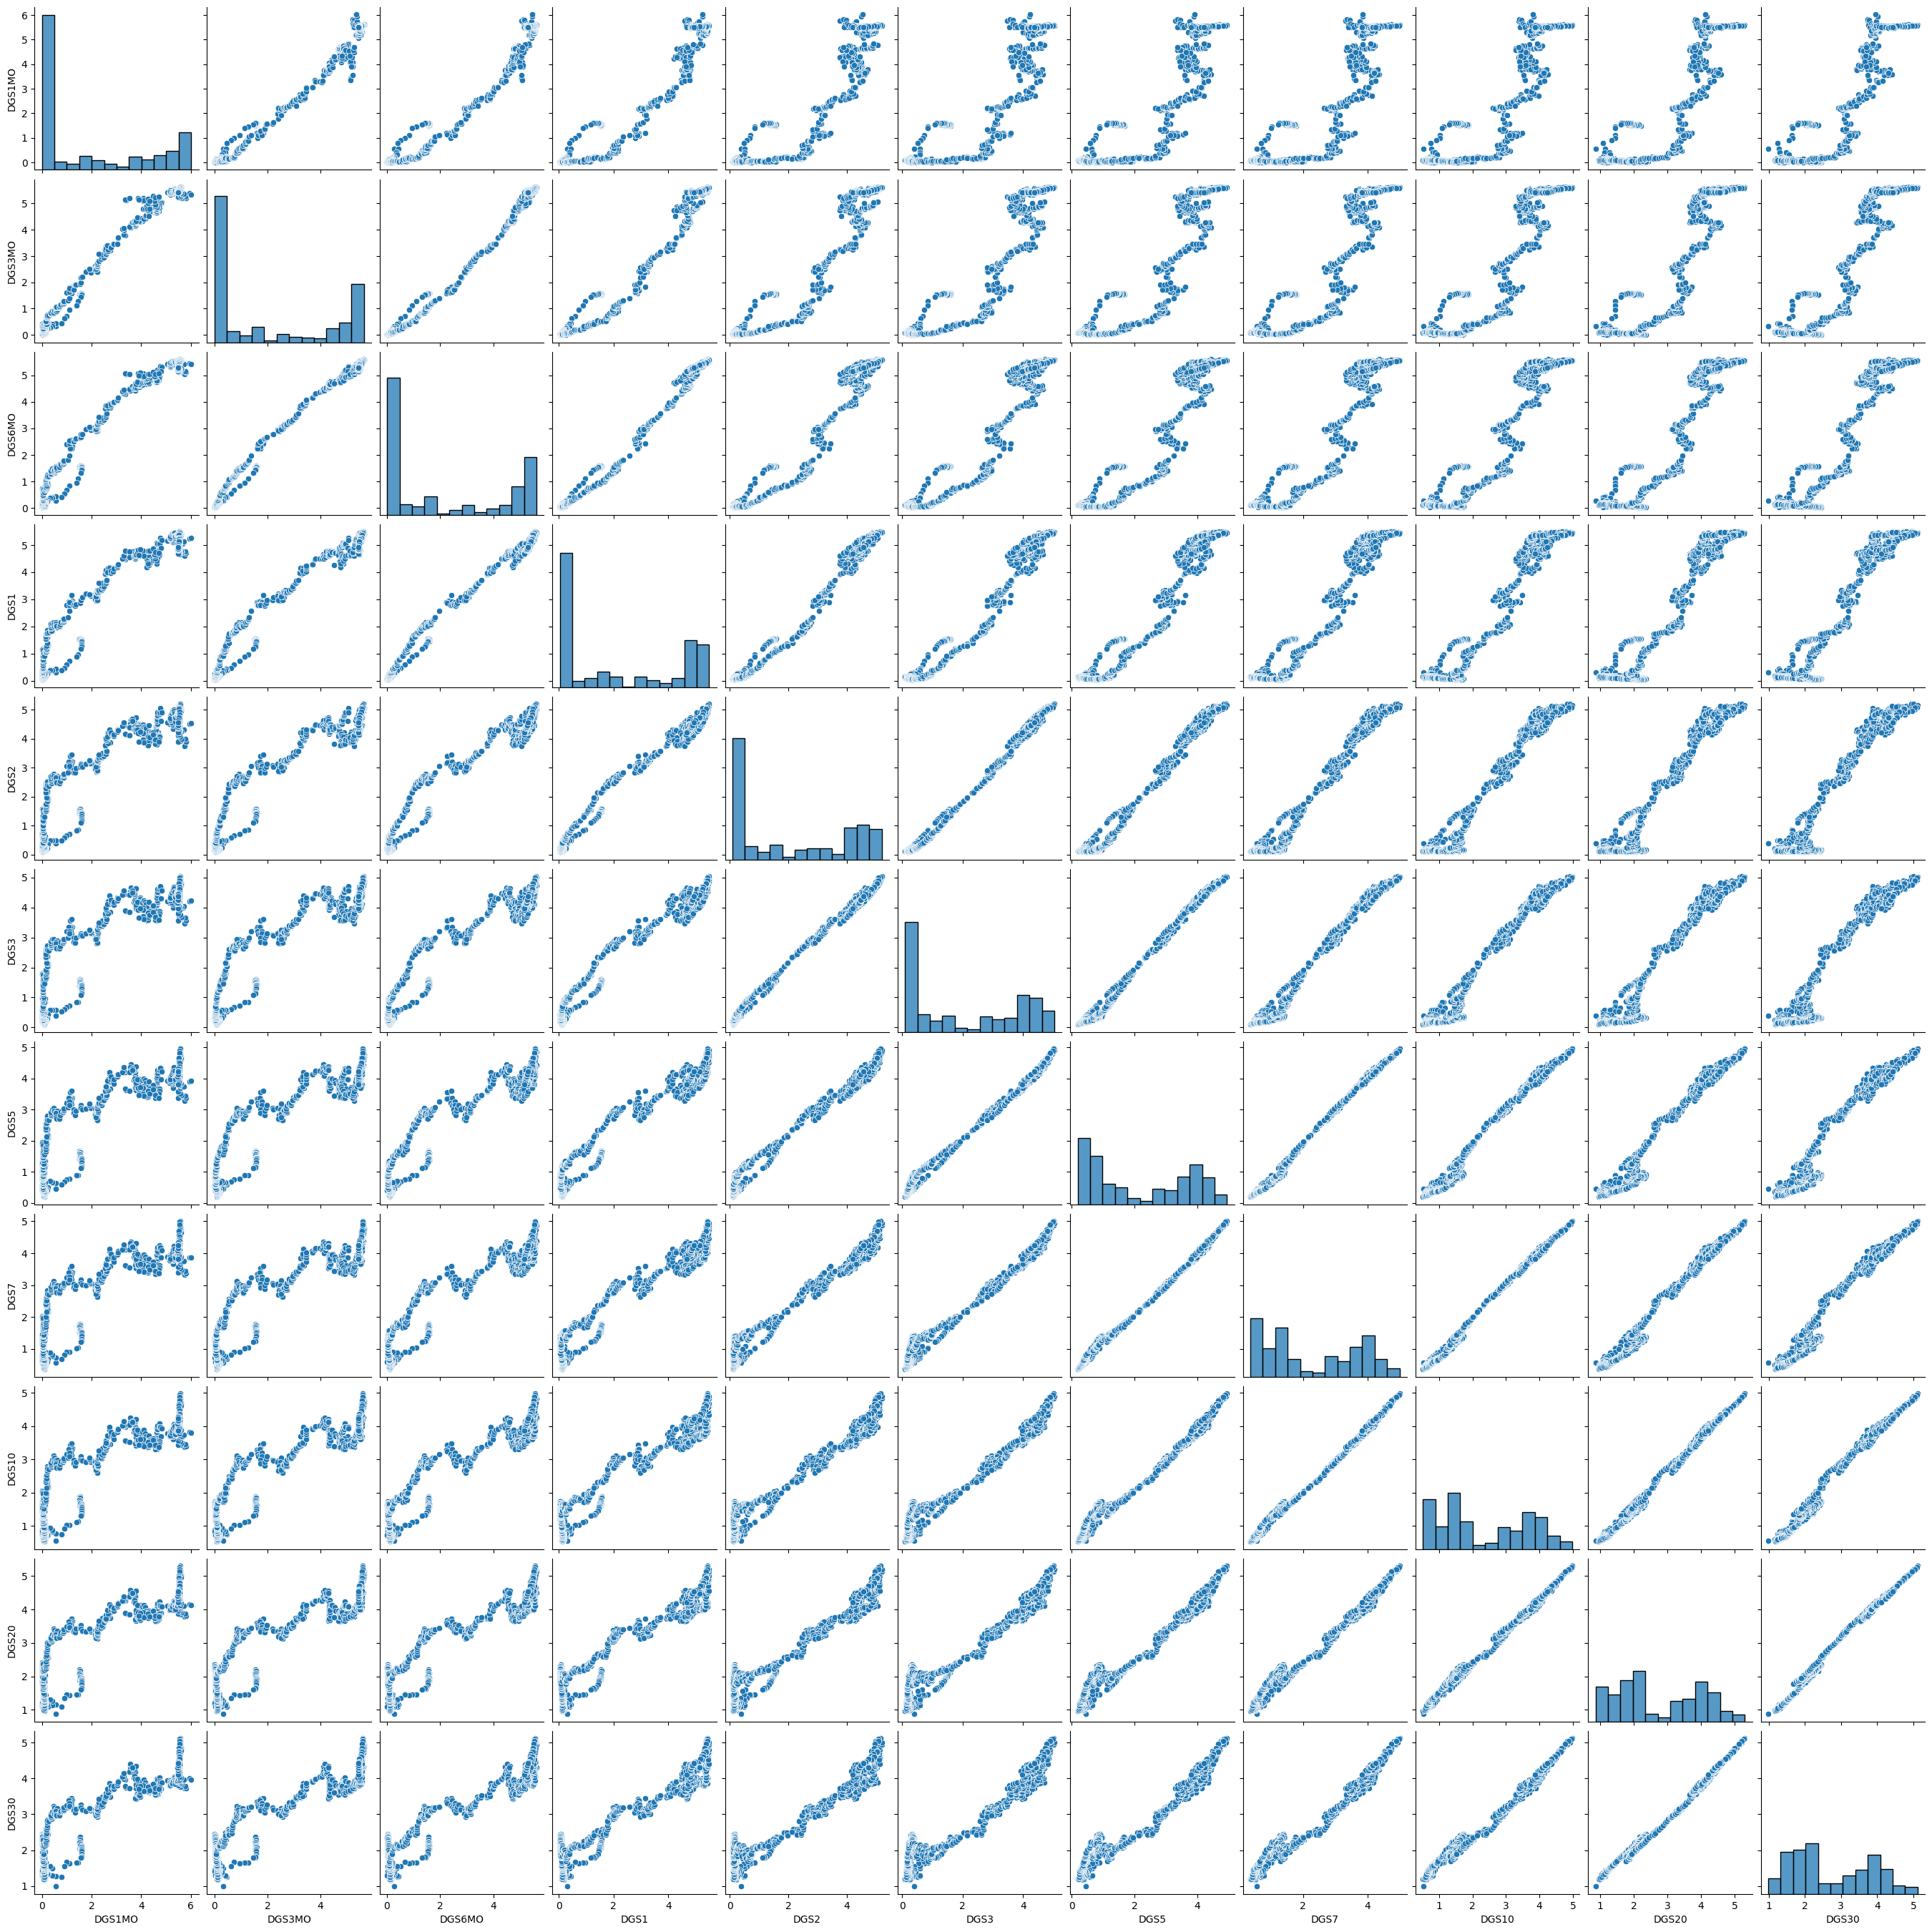

In [5]:
# correlation among tenors
sns.pairplot(df)

In [6]:
# covariance
df.cov()

,DGS1MO,DGS3MO,DGS6MO,DGS1,DGS2,DGS3,DGS5,DGS7,DGS10,DGS20,DGS30
DGS1MO,5.022086,5.085167,5.017070,4.719184,4.074872,3.671157,3.186955,2.915597,2.673174,2.488827,2.225688
DGS3MO,5.085167,5.209798,5.174023,4.894805,4.253580,3.845902,3.338368,3.047667,2.786282,2.591781,2.306556
DGS6MO,5.017070,5.174023,5.180451,4.935615,4.325142,3.926539,3.409790,3.106912,2.831811,2.631083,2.328653
DGS1,4.719184,4.894805,4.935615,4.741347,4.195656,3.826082,3.327448,3.027918,2.752822,2.553722,2.249070
DGS2,4.074872,4.253580,4.325142,4.195656,3.766527,3.458979,3.019613,2.746035,2.489908,2.305270,2.017112
DGS3,3.671157,3.845902,3.926539,3.826082,3.458979,3.190987,2.795739,2.544557,2.306303,2.135417,1.862117
DGS5,3.186955,3.338368,3.409790,3.327448,3.019613,2.795739,2.466271,2.254374,2.049937,1.903069,1.658184
DGS7,2.915597,3.047667,3.106912,3.027918,2.746035,2.544557,2.254374,2.068850,1.888131,1.757923,1.534109
DGS10,2.673174,2.786282,2.831811,2.752822,2.489908,2.306303,2.049937,1.888131,1.730325,1.616199,1.414305
DGS20,2.488827,2.591781,2.631083,2.553722,2.305270,2.135417,1.903069,1.757923,1.616199,1.516332,1.328475


In [7]:
# correlation
df.corr()

,DGS1MO,DGS3MO,DGS6MO,DGS1,DGS2,DGS3,DGS5,DGS7,DGS10,DGS20,DGS30
DGS1MO,1.000000,0.994152,0.983613,0.967106,0.936918,0.917061,0.905552,0.904526,0.906821,0.901894,0.918143
DGS3MO,0.994152,1.000000,0.995942,0.984859,0.960226,0.943247,0.931329,0.928309,0.928006,0.922127,0.934204
DGS6MO,0.983613,0.995942,1.000000,0.995879,0.979143,0.965747,0.953945,0.949032,0.945838,0.938758,0.945821
DGS1,0.967106,0.984859,0.995879,1.000000,0.992838,0.983651,0.973061,0.966783,0.961089,0.952414,0.954861
DGS2,0.936918,0.960226,0.979143,0.992838,1.000000,0.997734,0.990741,0.983719,0.975324,0.964615,0.960832
DGS3,0.917061,0.943247,0.965747,0.983651,0.997734,1.000000,0.996584,0.990342,0.981499,0.970785,0.963679
DGS5,0.905552,0.931329,0.953945,0.973061,0.990741,0.996584,1.000000,0.998024,0.992330,0.984095,0.976113
DGS7,0.904526,0.928309,0.949032,0.966783,0.983719,0.990342,0.998024,1.000000,0.997939,0.992518,0.986007
DGS10,0.906821,0.928006,0.945838,0.961089,0.975324,0.981499,0.992330,0.997939,1.000000,0.997778,0.993957
DGS20,0.901894,0.922127,0.938758,0.952414,0.964615,0.970785,0.984095,0.992518,0.997778,1.000000,0.997342


In [8]:
# perform PCA
from sklearn.decomposition import PCA
pca = PCA().fit(df)        # call fit or fit_transform

In [9]:
print(pca.explained_variance_ratio_)
print(np.cumsum(pca.explained_variance_ratio_))

[9.68495904e-01 2.50794985e-02 5.26709501e-03 7.85465789e-04
 2.14703565e-04 7.74932628e-05 3.89071453e-05 2.01198202e-05
 1.36052517e-05 4.67205117e-06 2.53593361e-06]
[0.9684959  0.9935754  0.9988425  0.99962796 0.99984267 0.99992016
 0.99995907 0.99997919 0.99999279 0.99999746 1.        ]


Text(0, 0.5, 'cumulative explained variance')

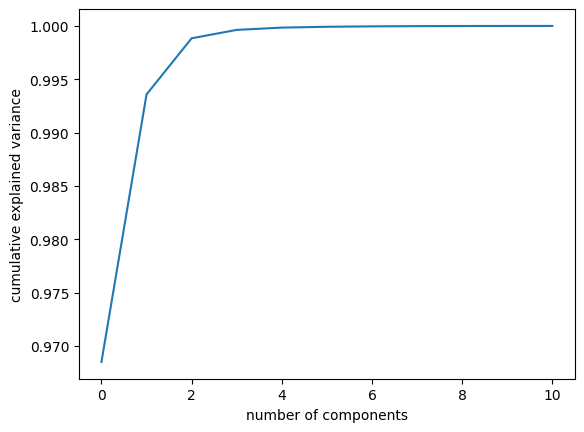

In [10]:
plt.plot(pca.explained_variance_ratio_.cumsum())
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')

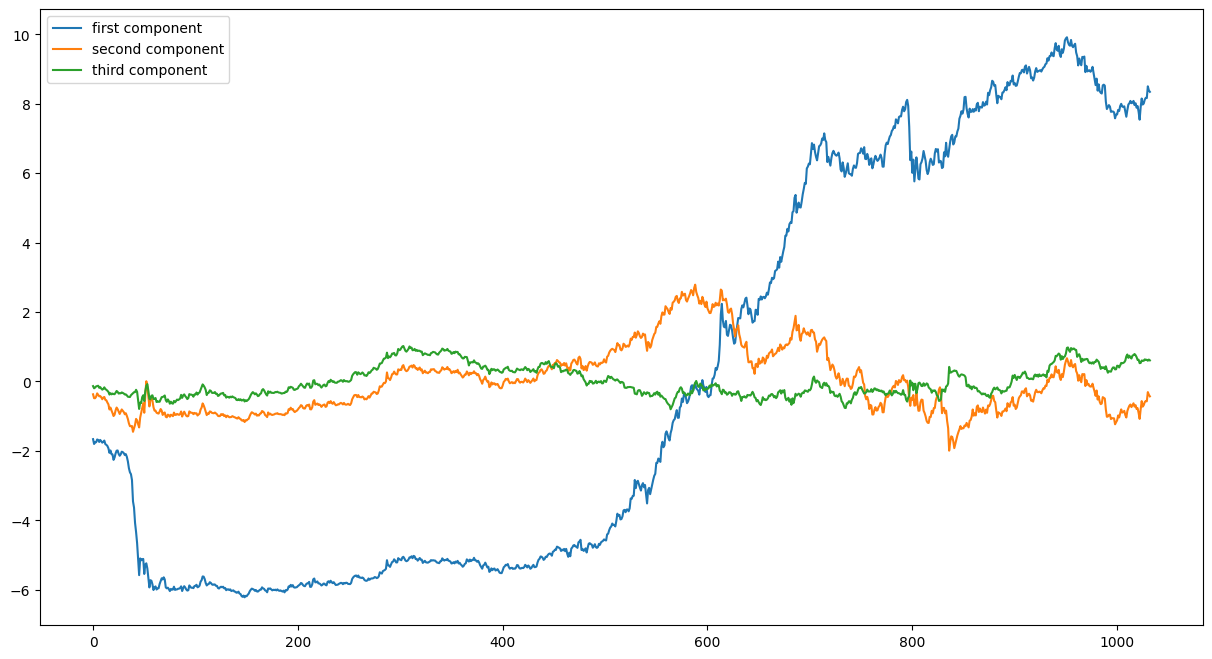

In [11]:
df_pca = pca.transform(df)            # eigenvector
plt.figure(figsize=(15,8))
plt.plot(df_pca[:, 0], label='first component')
plt.plot(df_pca[:, 1], label='second component')
plt.plot(df_pca[:, 2], label='third component')
plt.legend()
plt.show()